# Telco Customer Churn Prediction

This code uses logistic regression, random forest, XGBoost and neural nets to predict the customer churn rate and compared the performances of these three methods.

In [1]:
import numpy as np
import pandas as pd
import pyrsm as rsm
import matplotlib.pyplot as plt
import seaborn as sns
import qgrid
from math import sqrt
import re

from sklearn.linear_model import LogisticRegression
import statsmodels.formula.api as smf
from statsmodels.genmod.families import Binomial
from statsmodels.genmod.families.links import logit

from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


from sklearn.inspection import permutation_importance, plot_partial_dependence
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn import metrics
from sklearn.metrics import roc_auc_score, accuracy_score, confusion_matrix, recall_score, classification_report

## Read data and data quality check

In [2]:
telco = pd.read_csv("./data/Telco-Customer-Churn.csv")
telco.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
telco.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [4]:
telco.duplicated().sum()

0

## Feature engineering

In [5]:
telco['TotalCharges'] = telco['TotalCharges'].replace(' ', 'NaN')
telco['TotalCharges'] = telco['TotalCharges'].astype(float)
mean_totalcharges = np.nanmean(telco['TotalCharges'])
telco['TotalCharges'] = telco['TotalCharges'].fillna(mean_totalcharges)

In [6]:
telco['SeniorCitizen'] = telco['SeniorCitizen'].astype(int)

is_cat = ['gender', 
          'Partner', 
          'Dependents',
          'PhoneService', 
          'MultipleLines', 
          'InternetService',
          'OnlineSecurity', 
          'OnlineBackup', 
          'DeviceProtection', 
          'TechSupport',
          'StreamingTV', 
          'StreamingMovies', 
          'Contract', 
          'PaperlessBilling',
          'PaymentMethod',
          'Churn']

dummies = pd.get_dummies(telco[is_cat], drop_first = True)

dummies = dummies.drop(['MultipleLines_No phone service', 
                        'OnlineSecurity_No internet service', 
                        'OnlineBackup_No internet service',
                        'DeviceProtection_No internet service',
                        'TechSupport_No internet service',
                        'StreamingTV_No internet service',
                        'StreamingMovies_No internet service'], axis=1)  

dummies = dummies.rename(columns={'InternetService_Fiber optic': 'InternetService_FiberOptic',
                                 'Contract_One year': 'Contract_OneYear',
                                 'Contract_Two year': 'Contract_TwoYear',
                                 'PaymentMethod_Credit card (automatic)': 'CreditCard',
                                 'PaymentMethod_Electronic check': 'ElectronicCheck',
                                 'PaymentMethod_Mailed check': 'MailedCheck'})

telco_num = telco[['customerID', 'SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']]
telco_dum = pd.concat([telco_num, dummies], axis=1)
telco_dum.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   customerID                  7043 non-null   object 
 1   SeniorCitizen               7043 non-null   int64  
 2   tenure                      7043 non-null   int64  
 3   MonthlyCharges              7043 non-null   float64
 4   TotalCharges                7043 non-null   float64
 5   gender_Male                 7043 non-null   uint8  
 6   Partner_Yes                 7043 non-null   uint8  
 7   Dependents_Yes              7043 non-null   uint8  
 8   PhoneService_Yes            7043 non-null   uint8  
 9   MultipleLines_Yes           7043 non-null   uint8  
 10  InternetService_FiberOptic  7043 non-null   uint8  
 11  InternetService_No          7043 non-null   uint8  
 12  OnlineSecurity_Yes          7043 non-null   uint8  
 13  OnlineBackup_Yes            7043 

In [7]:
telco_dum.head()                                                  

,customerID,SeniorCitizen,tenure,MonthlyCharges,TotalCharges,gender_Male,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_Yes,...,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Contract_OneYear,Contract_TwoYear,PaperlessBilling_Yes,CreditCard,ElectronicCheck,MailedCheck,Churn_Yes
0,7590-VHVEG,0,1,29.85,29.85,0,1,0,0,0,...,0,0,0,0,0,1,0,1,0,0
1,5575-GNVDE,0,34,56.95,1889.50,1,0,0,1,0,...,0,0,0,1,0,0,0,0,1,0
2,3668-QPYBK,0,2,53.85,108.15,1,0,0,1,0,...,0,0,0,0,0,1,0,0,1,1
3,7795-CFOCW,0,45,42.30,1840.75,1,0,0,0,0,...,1,0,0,1,0,0,0,0,0,0
4,9237-HQITU,0,2,70.70,151.65,0,0,0,1,0,...,0,0,0,0,0,1,0,1,0,1


## EDA

In [8]:
telco_dum.Churn_Yes.mean()

0.2653698707936959

No plot for customerID (type object)


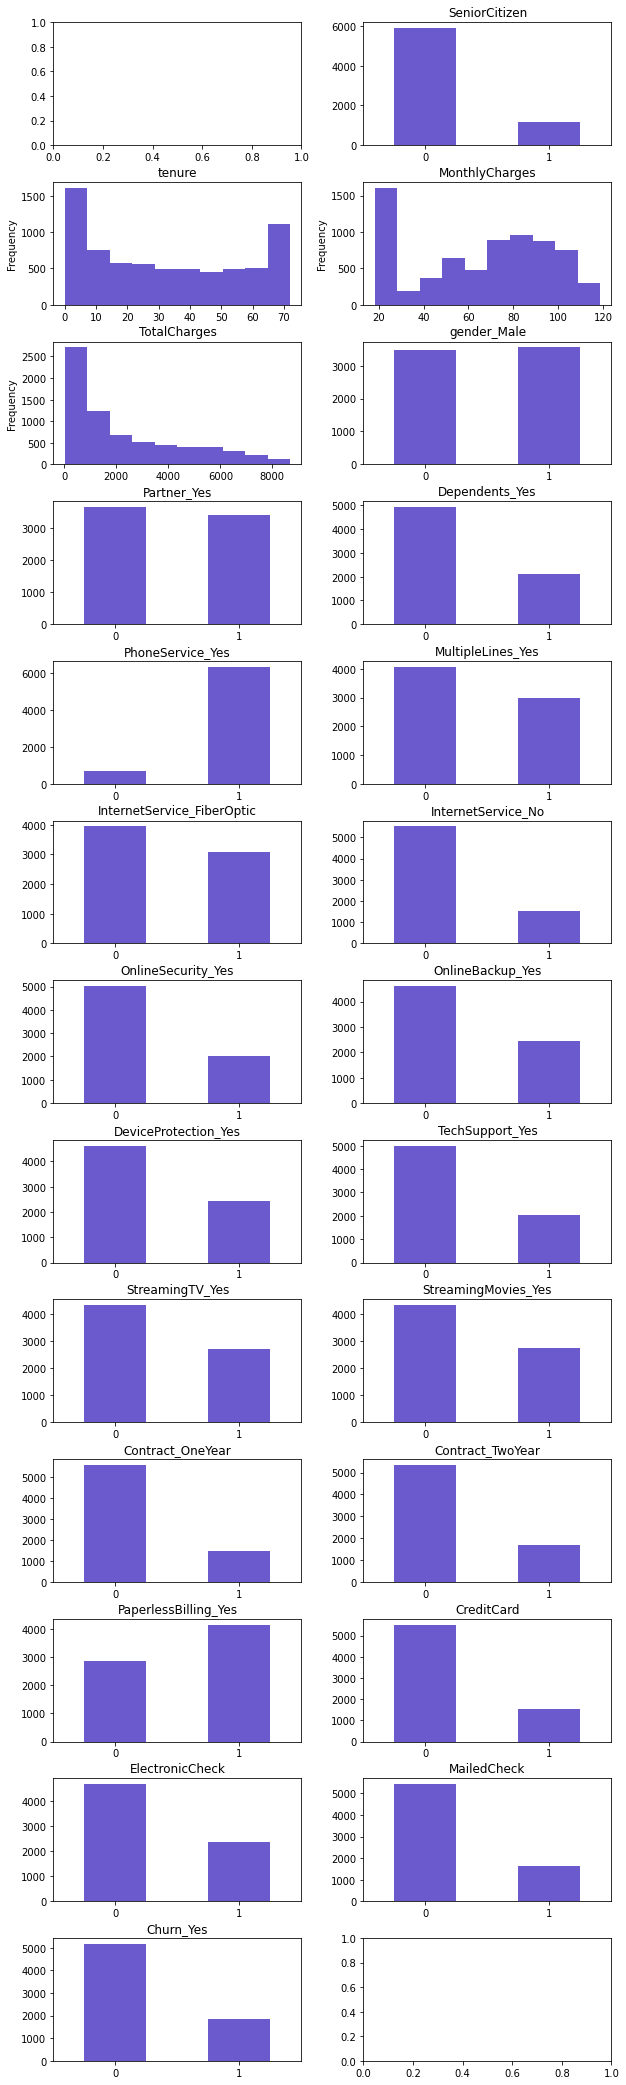

In [9]:
rsm.distr_plot(telco_dum)

- ### numeric variables

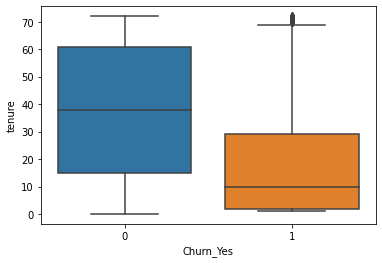

In [10]:
sns.boxplot(x='Churn_Yes',
            y='tenure',
            data=telco_dum)
plt.show()

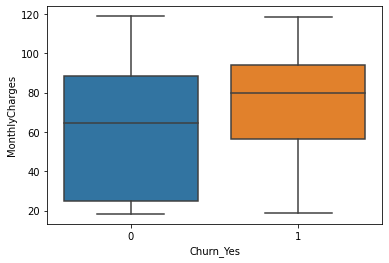

In [11]:
sns.boxplot(x='Churn_Yes',
            y='MonthlyCharges',
            data=telco_dum)
plt.show()

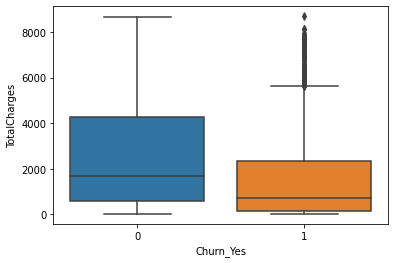

In [12]:
sns.boxplot(x='Churn_Yes',
            y='TotalCharges',
            data=telco_dum)
plt.show()

In [13]:
telco_dum[['Churn_Yes','tenure', 'MonthlyCharges', 'TotalCharges']].corr()

,Churn_Yes,tenure,MonthlyCharges,TotalCharges
Churn_Yes,1.000000,-0.352229,0.193356,-0.199428
tenure,-0.352229,1.000000,0.247900,0.824757
MonthlyCharges,0.193356,0.247900,1.000000,0.650468
TotalCharges,-0.199428,0.824757,0.650468,1.000000


The distributions of `tenure`, `MonthlyCharges` and `TotalCharges` are significantly different between churn and non-churn group. Besides, `TotalCharges` is highly related with `tenure` and `MonthlyCharges`. It makes sense because TotalCharges should be related to tenure * MonthlyCharges. 

According to the plots, a customer with higher monthly charges and shorter period tends to switch his/her provider.

- ### dummies


Cross-tabs
Variables: Churn_Yes, SeniorCitizen
Null hyp: there is no association between Churn_Yes and SeniorCitizen
Alt. hyp: there is an association between Churn_Yes and SeniorCitizen

Column percentages:

SeniorCitizen       0       1   Total
Churn_Yes                            
0              76.39%  58.32%  73.46%
1              23.61%  41.68%  26.54%
Total          100.0%  100.0%  100.0%

Chi-squared: 160.35 df(1), p.value 0.0



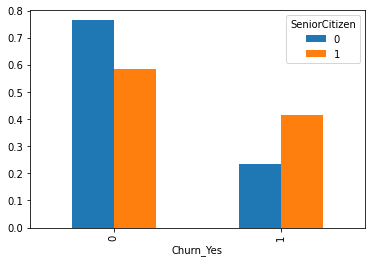

In [14]:
ct = rsm.cross_tabs(telco_dum, 'Churn_Yes', 'SeniorCitizen')
ct.summary(output = 'perc_col')
ct.plot(output = 'perc_col')

Senior citizens are more likely to churn. 


Cross-tabs
Variables: Churn_Yes, gender_Male
Null hyp: there is no association between Churn_Yes and gender_Male
Alt. hyp: there is an association between Churn_Yes and gender_Male

Column percentages:

gender_Male       0       1   Total
Churn_Yes                          
0            73.08%  73.84%  73.46%
1            26.92%  26.16%  26.54%
Total        100.0%  100.0%  100.0%

Chi-squared: 0.52 df(1), p.value 0.47



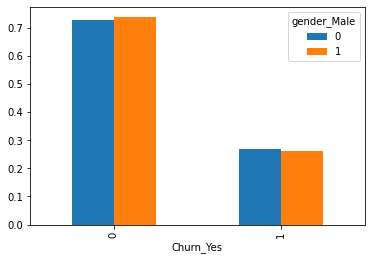

In [15]:
ct = rsm.cross_tabs(telco_dum, 'Churn_Yes', 'gender_Male')
ct.summary(output = 'perc_col')
ct.plot(output = 'perc_col')

It seems that there is no difference in churn rate in two genders.


Cross-tabs
Variables: Churn_Yes, Partner_Yes
Null hyp: there is no association between Churn_Yes and Partner_Yes
Alt. hyp: there is an association between Churn_Yes and Partner_Yes

Column percentages:

Partner_Yes       0       1   Total
Churn_Yes                          
0            67.04%  80.34%  73.46%
1            32.96%  19.66%  26.54%
Total        100.0%  100.0%  100.0%

Chi-squared: 159.41 df(1), p.value 0.0



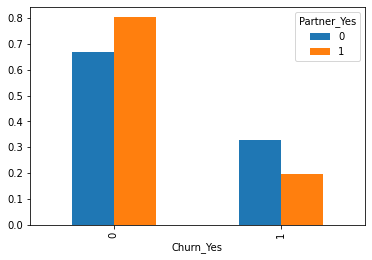

In [16]:
ct = rsm.cross_tabs(telco_dum, 'Churn_Yes', 'Partner_Yes')
ct.summary(output = 'perc_col')
ct.plot(output = 'perc_col')


Cross-tabs
Variables: Churn_Yes, Dependents_Yes
Null hyp: there is no association between Churn_Yes and Dependents_Yes
Alt. hyp: there is an association between Churn_Yes and Dependents_Yes

Column percentages:

Dependents_Yes       0       1   Total
Churn_Yes                             
0               68.72%  84.55%  73.46%
1               31.28%  15.45%  26.54%
Total           100.0%  100.0%  100.0%

Chi-squared: 189.94 df(1), p.value 0.0



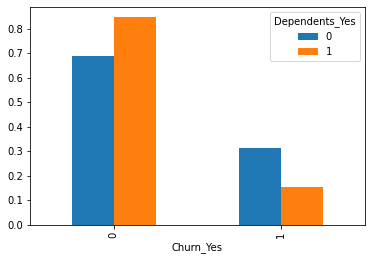

In [17]:
ct = rsm.cross_tabs(telco_dum, 'Churn_Yes', 'Dependents_Yes')
ct.summary(output = 'perc_col')
ct.plot(output = 'perc_col')

Customers with partner or dependents have a lower churn rate. 


Cross-tabs
Variables: Churn_Yes, PhoneService_Yes
Null hyp: there is no association between Churn_Yes and PhoneService_Yes
Alt. hyp: there is an association between Churn_Yes and PhoneService_Yes

Column percentages:

PhoneService_Yes       0       1   Total
Churn_Yes                               
0                 75.07%  73.29%  73.46%
1                 24.93%  26.71%  26.54%
Total             100.0%  100.0%  100.0%

Chi-squared: 1.0 df(1), p.value 0.32



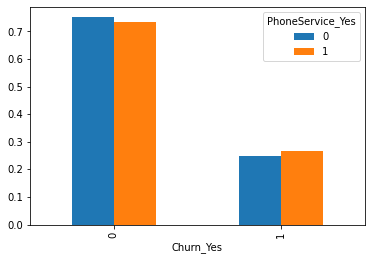

In [18]:
ct = rsm.cross_tabs(telco_dum, 'Churn_Yes', 'PhoneService_Yes')
ct.summary(output = 'perc_col')
ct.plot(output = 'perc_col')

The p.value is much higher than 0.1. Using a confidence level of 0.90, we should accept our null hypo that there is no association between Churn_Yes and PhoneService_Yes.


Cross-tabs
Variables: Churn_Yes, InternetService_No
Null hyp: there is no association between Churn_Yes and InternetService_No
Alt. hyp: there is an association between Churn_Yes and InternetService_No

Column percentages:

InternetService_No       0       1   Total
Churn_Yes                                 
0                   68.17%   92.6%  73.46%
1                   31.83%    7.4%  26.54%
Total               100.0%  100.0%  100.0%

Chi-squared: 365.77 df(1), p.value 0.0



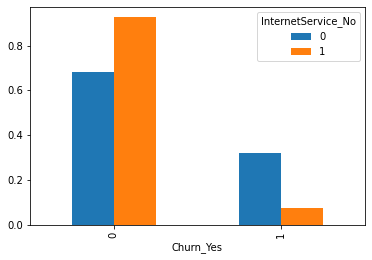

In [19]:
ct = rsm.cross_tabs(telco_dum, 'Churn_Yes', 'InternetService_No')
ct.summary(output = 'perc_col')
ct.plot(output = 'perc_col')


Cross-tabs
Variables: Churn, InternetService
Null hyp: there is no association between Churn and InternetService
Alt. hyp: there is an association between Churn and InternetService

Column percentages:

InternetService     DSL Fiber optic      No   Total
Churn                                              
No               81.04%      58.11%   92.6%  73.46%
Yes              18.96%      41.89%    7.4%  26.54%
Total            100.0%      100.0%  100.0%  100.0%

Chi-squared: 732.31 df(2), p.value 0.0



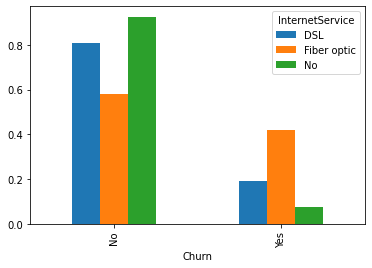

In [20]:
ct = rsm.cross_tabs(telco, 'Churn', 'InternetService')
ct.summary(output = 'perc_col')
ct.plot(output = 'perc_col')

People with no internet service only has a churn rate of 7.4%. If a customer's internet service is through Fiber Optic, then he/she is very likely to churn (41.89%). 


Cross-tabs
Variables: Churn, Contract
Null hyp: there is no association between Churn and Contract
Alt. hyp: there is an association between Churn and Contract

Column percentages:

Contract Month-to-month One year Two year   Total
Churn                                            
No               57.29%   88.73%   97.17%  73.46%
Yes              42.71%   11.27%    2.83%  26.54%
Total            100.0%   100.0%   100.0%  100.0%

Chi-squared: 1184.6 df(2), p.value 0.0



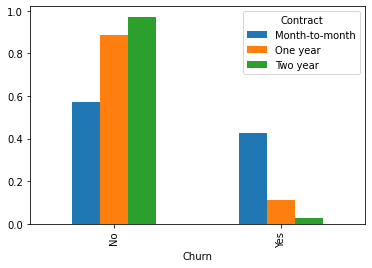

In [21]:
ct = rsm.cross_tabs(telco, 'Churn', 'Contract')
ct.summary(output = 'perc_col')
ct.plot(output = 'perc_col')

Customers with a contract of month-to-month payment have a significantly higher churn rate, which may because that this kind of payment allows more flexibility for customer to change their service provider.


Cross-tabs
Variables: Churn_Yes, StreamingTV_Yes
Null hyp: there is no association between Churn_Yes and StreamingTV_Yes
Alt. hyp: there is an association between Churn_Yes and StreamingTV_Yes

Column percentages:

StreamingTV_Yes       0       1   Total
Churn_Yes                              
0                75.67%  69.93%  73.46%
1                24.33%  30.07%  26.54%
Total            100.0%  100.0%  100.0%

Chi-squared: 28.16 df(1), p.value 0.0



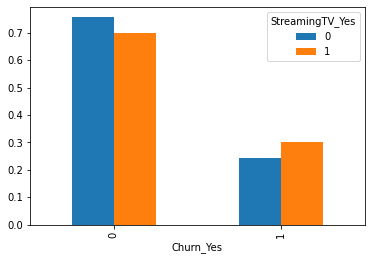

In [22]:
ct = rsm.cross_tabs(telco_dum, 'Churn_Yes', 'StreamingTV_Yes')
ct.summary(output = 'perc_col')
ct.plot(output = 'perc_col')


Cross-tabs
Variables: Churn_Yes, StreamingMovies_Yes
Null hyp: there is no association between Churn_Yes and StreamingMovies_Yes
Alt. hyp: there is an association between Churn_Yes and StreamingMovies_Yes

Column percentages:

StreamingMovies_Yes       0       1   Total
Churn_Yes                                  
0                    75.62%  70.06%  73.46%
1                    24.38%  29.94%  26.54%
Total                100.0%  100.0%  100.0%

Chi-squared: 26.54 df(1), p.value 0.0



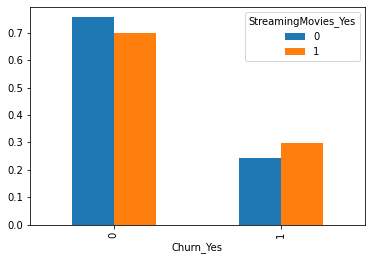

In [23]:
ct = rsm.cross_tabs(telco_dum,'Churn_Yes', 'StreamingMovies_Yes')
ct.summary(output = 'perc_col')
ct.plot(output = 'perc_col')


Cross-tabs
Variables: Churn_Yes, PaperlessBilling_Yes
Null hyp: there is no association between Churn_Yes and PaperlessBilling_Yes
Alt. hyp: there is an association between Churn_Yes and PaperlessBilling_Yes

Column percentages:

PaperlessBilling_Yes       0       1   Total
Churn_Yes                                   
0                     83.67%  66.43%  73.46%
1                     16.33%  33.57%  26.54%
Total                 100.0%  100.0%  100.0%

Chi-squared: 259.16 df(1), p.value 0.0



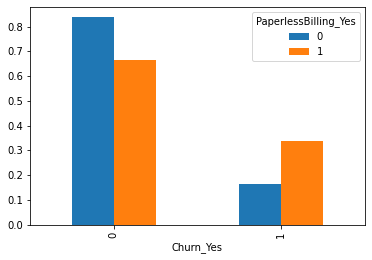

In [24]:
ct = rsm.cross_tabs(telco_dum, 'Churn_Yes','PaperlessBilling_Yes')
ct.summary(output = 'perc_col')
ct.plot(output = 'perc_col')


Cross-tabs
Variables: Churn, PaymentMethod
Null hyp: there is no association between Churn and PaymentMethod
Alt. hyp: there is an association between Churn and PaymentMethod

Column percentages:

PaymentMethod Bank transfer (automatic) Credit card (automatic)  \
Churn                                                             
No                               83.29%                  84.76%   
Yes                              16.71%                  15.24%   
Total                            100.0%                  100.0%   

PaymentMethod Electronic check Mailed check   Total  
Churn                                                
No                      54.71%       80.89%  73.46%  
Yes                     45.29%       19.11%  26.54%  
Total                   100.0%       100.0%  100.0%  

Chi-squared: 648.14 df(3), p.value 0.0



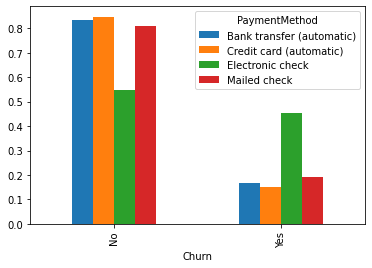

In [25]:
ct = rsm.cross_tabs(telco, 'Churn', 'PaymentMethod')
ct.summary(output = 'perc_col')
ct.plot(output = 'perc_col')

The average churn rate of users who make payment by electronic is significantly higher than others.


Cross-tabs
Variables: PaymentMethod, PaperlessBilling
Null hyp: there is no association between PaymentMethod and PaperlessBilling
Alt. hyp: there is an association between PaymentMethod and PaperlessBilling

Column percentages:

PaperlessBilling               No     Yes   Total
PaymentMethod                                    
Bank transfer (automatic)  22.74%  21.36%  21.92%
Credit card (automatic)    22.28%  21.15%  21.61%
Electronic check           21.69%  41.76%  33.58%
Mailed check               33.29%  15.73%  22.89%
Total                      100.0%  100.0%  100.0%

Chi-squared: 435.69 df(3), p.value 0.0



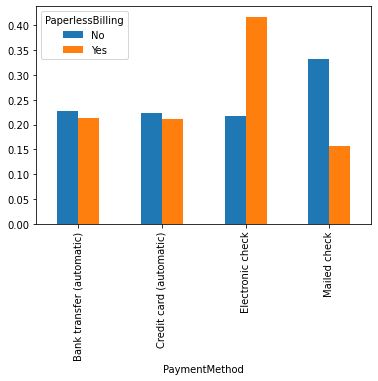

In [26]:
ct = rsm.cross_tabs(telco, 'PaymentMethod', 'PaperlessBilling')
ct.summary(output = 'perc_col')
ct.plot(output = 'perc_col')

Paperless billing cusotmers are more likely to pay by electronic check, while paper billing ones tend to pay by mailed check.

## Split the data

In [27]:
train, test = train_test_split(telco_dum, test_size=0.2, random_state=42, stratify=telco_dum['Churn_Yes'])
train2, val = train_test_split(train, test_size=0.25, random_state=42, stratify=train['Churn_Yes'])

## Logistic regression

In [28]:
idvar = 'customerID'

evar = ['tenure', 'TotalCharges', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_FiberOptic',
       'InternetService_No', 'OnlineBackup_Yes', 'TechSupport_Yes', 
       'StreamingMovies_Yes', 'Contract_OneYear', 'Contract_TwoYear',
       'PaperlessBilling_Yes', 'ElectronicCheck']

rvar = 'Churn_Yes'
form = "Churn_Yes ~ " + " + ".join(evar)  

In [29]:
lr_mod = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    data=train2
)
lr = lr_mod.fit()

In [30]:
lr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:              Churn_Yes   No. Observations:                 4225
Model:                            GLM   Df Residuals:                     4210
Model Family:                Binomial   Df Model:                           14
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1736.7
Date:                Mon, 05 Apr 2021   Deviance:                       3473.3
Time:                        06:41:05   Pearson chi2:                 4.87e+03
No. Iterations:                     7                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.0722      0.177      0.408      0.683      -0.275       0.419
tenure                        -0.0572      0.008     -7.403      0.000      -0.072      -0.042
TotalCharges                   0.0003    8.7e-05      3.365      0.001       0.000       0.000
Dependents_Yes                -0.2576      0.105     -2.445      0.014      -0.464      -0.051
PhoneService_Yes              -0.7724      0.167     -4.619      0.000      -1.100      -0.445
MultipleLines_Yes              0.3471      0.104      3.345      0.001       0.144       0.551
InternetService_FiberOptic     0.9079      0.125      7.255      0.000       0.663       1.153
InternetService_No            -0.6443      0.174     -3.695      0.000      -0.986      -0.303
OnlineBackup_Yes              -0.2029      0.100     -2.037      0.042      -0.398      -0.008
TechSupport_Yes               -0.3936      0.110     -3.574      0.000      -0.609      -0.178
StreamingMovies_Yes            0.2735      0.101      2.697      0.007       0.075       0.472
Contract_OneYear              -0.7641      0.141     -5.416      0.000      -1.041      -0.488
Contract_TwoYear              -1.6373      0.234     -6.986      0.000      -2.097      -1.178
PaperlessBilling_Yes           0.3564      0.096      3.714      0.000       0.168       0.544
ElectronicCheck                0.3837      0.089      4.295      0.000       0.209       0.559
==============================================================================================
"""

In [31]:
rsm.vif(lr_mod)

,variable,vif,Rsq
0,TotalCharges,9.145,0.891
1,tenure,6.795,0.853
2,Contract_TwoYear,2.602,0.616
3,InternetService_No,2.409,0.585
4,InternetService_FiberOptic,2.244,0.554
5,Contract_OneYear,1.607,0.378
6,StreamingMovies_Yes,1.603,0.376
7,TechSupport_Yes,1.530,0.346
8,OnlineBackup_Yes,1.476,0.322
9,MultipleLines_Yes,1.454,0.312


####  evaluation

In [32]:
rsm.model_fit(lr)


Pseudo R-squared (McFadden): 0.29
Pseudo R-squared (McFadden adjusted): 0.284
Log-likelihood: -1736.665, AIC: 3503.331, BIC: 3598.562
Chi-squared: 4870.946 df(14), p.value < 0.001 
Nr obs: 4,225



- train dataset

In [33]:
roc_auc_score(train2.Churn_Yes, lr.predict(train2))

0.8508123384864397

In [34]:
# use 0.5 as cutoff
accuracy_score(train2.Churn_Yes, lr.predict(train2)>0.5)

0.8049704142011834

- validation dataset

In [35]:
roc_auc_score(val.Churn_Yes, lr.predict(val))

0.8345036038130667

In [36]:
# use 0.5 as cutoff
accuracy_score(val.Churn_Yes, lr.predict(val)>0.5)

0.8062455642299503

In [37]:
# retrain the model with both train and validation data
lr_mod = smf.glm(
    formula=form,
    family=Binomial(link=logit()),
    data=train
)
lr = lr_mod.fit()

- test dataset

In [38]:
auc_lr = roc_auc_score(test.Churn_Yes, lr.predict(test))

In [39]:
# use 0.5 as cutoff
acc_lr = accuracy_score(test.Churn_Yes, lr.predict(test)>0.5)

In [40]:
print(f'''The accuracy on test set is {round(100*acc_lr, 2)}%.
The AUC score on test set is {round(auc_lr,3)}.''')

The accuracy on test set is 79.35%.
The AUC score on test set is 0.84.


## Machine learning

In [41]:
evar_ml = ['SeniorCitizen', 'tenure', 'MonthlyCharges',
       'TotalCharges', 'gender_Male', 'Partner_Yes', 'Dependents_Yes',
       'PhoneService_Yes', 'MultipleLines_Yes', 'InternetService_FiberOptic',
       'InternetService_No', 'OnlineSecurity_Yes', 'OnlineBackup_Yes',
       'DeviceProtection_Yes', 'TechSupport_Yes', 'StreamingTV_Yes',
       'StreamingMovies_Yes', 'Contract_OneYear', 'Contract_TwoYear',
       'PaperlessBilling_Yes', 'CreditCard', 'ElectronicCheck', 'MailedCheck']

In [42]:
X_train = train[evar_ml]
y_train = train['Churn_Yes']

X_test = test[evar_ml]
y_test = test['Churn_Yes']

### Random forest

In [43]:
max_feat = sqrt(X_train.shape[1])

clf2 = RandomForestClassifier(random_state=1234, n_jobs=4)

param_grid = {
    "n_estimators": list(range(100, 501, 100)),
    "max_features": range(4, 7),
    "max_depth": range(1, 5)
}

scoring = {"AUC": "roc_auc"}

clf2_cv = GridSearchCV(
    clf2, param_grid, scoring=scoring, cv=5, n_jobs=4, refit="AUC", verbose=5
).fit(X_train, y_train)

clf2_cv.best_params_

Fitting 5 folds for each of 60 candidates, totalling 300 fits


{'max_depth': 4, 'max_features': 4, 'n_estimators': 400}

In [44]:
clf2_cv.best_score_

0.8442452826152307

In [45]:
# to use obb_score, have to retrain the model
clf2 = RandomForestClassifier(
    n_estimators=clf2_cv.best_params_["n_estimators"],
    max_features=clf2_cv.best_params_["max_features"],
    max_depth = clf2_cv.best_params_["max_depth"],
    oob_score=True,
    random_state=1234,
    n_jobs = 4
).fit(X_train, y_train)

pred = clf2.oob_decision_function_

#### evaluation

- train set

In [46]:
roc_auc_score(y_train, pred[:, 1])

0.8439446621217055

In [47]:
accuracy_score(y_train, pred[:, 1]>0.5)

0.791089811856585

- test set

In [48]:
auc_rf = roc_auc_score(y_test, clf2.predict_proba(X_test)[:, 1])

In [49]:
acc_rf = accuracy_score(y_test, clf2.predict(X_test))

In [50]:
print(f'''The accuracy on test set is {round(100*acc_rf, 2)}%.
The AUC score on test set is {round(auc_rf,3)}.''')

The accuracy on test set is 78.42%.
The AUC score on test set is 0.843.


In [51]:
print(classification_report(y_test, clf2.predict(X_test)))

              precision    recall  f1-score   support

           0       0.80      0.94      0.86      1035
           1       0.68      0.35      0.46       374

    accuracy                           0.78      1409
   macro avg       0.74      0.65      0.66      1409
weighted avg       0.77      0.78      0.76      1409



### Neural Network

In [52]:
# standardization
scaler = StandardScaler()
sf = scaler.fit(X_train[['tenure', 'MonthlyCharges', 'TotalCharges']])

X_train_std = X_train.copy()
X_train_std[['tenure', 'MonthlyCharges', 'TotalCharges']] = sf.transform(X_train_std[['tenure', 'MonthlyCharges', 'TotalCharges']])

X_test_std = X_test.copy()
X_test_std[['tenure', 'MonthlyCharges', 'TotalCharges']] = sf.transform(X_test_std[['tenure', 'MonthlyCharges', 'TotalCharges']])

In [53]:
clf3 = MLPClassifier(activation='tanh', solver='lbfgs', max_iter=1000000, random_state=1234)

hls = [(1,), (2,), (2, 2), (3,), (3, 3)]
alphas = [1, 0.5, 0.1, 0.05, 0.025, 0.01]

param_grid = {"hidden_layer_sizes": hls, "alpha": alphas}

scoring = {"AUC": "roc_auc"}

clf3_cv = GridSearchCV(clf3, 
                    param_grid,  
                    scoring=scoring, 
                    n_jobs=4, 
                    refit="AUC", 
                    cv=5, 
                    verbose=3).fit(X_train_std, y_train)

clf3_cv.best_params_


Fitting 5 folds for each of 30 candidates, totalling 150 fits


{'alpha': 0.05, 'hidden_layer_sizes': (2, 2)}

In [54]:
clf3_cv.best_score_

0.8474530429128665

#### evaluation

- train set

In [55]:
roc_auc_score(y_train, clf3_cv.predict_proba(X_train_std)[:, 1])

0.8577257201867221

In [56]:
accuracy_score(y_train, clf3_cv.predict(X_train_std))

0.8141640042598509

- test set

In [57]:
auc_nn = roc_auc_score(y_test, clf3_cv.predict_proba(X_test_std)[:, 1])

In [58]:
acc_nn = accuracy_score(y_test, clf3_cv.predict(X_test_std))

In [59]:
print(f'''The accuracy on test set is {round(100*acc_nn, 2)}%.
The AUC score on test set is {round(auc_nn,3)}.''')

The accuracy on test set is 79.63%.
The AUC score on test set is 0.843.


In [60]:
print(classification_report(y_test, clf3_cv.predict(X_test_std)))

              precision    recall  f1-score   support

           0       0.83      0.90      0.87      1035
           1       0.65      0.50      0.56       374

    accuracy                           0.80      1409
   macro avg       0.74      0.70      0.72      1409
weighted avg       0.78      0.80      0.79      1409



## Comparison

- Metrics

In [61]:
performance = pd.DataFrame({
    'Model': ['logistic regression', 'random forest', 'nerual network'],
    'AUC' : [auc_lr, auc_rf, auc_nn],
    'Accuracy': [acc_lr, acc_rf, acc_nn]
})

performance.sort_values('AUC', ascending=False)

,Model,AUC,Accuracy
1,random forest,0.843405,0.784244
2,nerual network,0.842905,0.796309
0,logistic regression,0.840404,0.793471


- Confusion matrices

In [62]:
# logistic regression
confusion_matrix(y_test, lr.predict(X_test)>0.5, normalize='all')

array([[0.64939674, 0.08516678],
       [0.12136267, 0.14407381]])

In [63]:
# random forest
confusion_matrix(y_test, clf2.predict(X_test), normalize='all')

array([[0.69056068, 0.04400284],
       [0.17175302, 0.09368346]])

In [64]:
# neural network
confusion_matrix(y_test, clf3_cv.predict(X_test_std), normalize='all')

array([[0.66430092, 0.0702626 ],
       [0.13342796, 0.13200852]])

- Recall score

In [65]:
# logistic regression
recall_score(test.Churn_Yes, lr.predict(test)>0.5).round(3)

0.543

In [66]:
# random forest
recall_score(y_test, clf2.predict(X_test)).round(3)

0.353

In [67]:
# neural network
recall_score(y_test, clf3_cv.predict(X_test_std)).round(3)

0.497

## Conclusion

The **AUC score** is chosen as the criteria, since it can represent the overall predictive performance with any cut-off churn rate, which is usually lower than 0.5 in order that the company can be proactive in churn management. According to the AUC scores of the three models, **random forest model** is the best choice. Its AUC score, accuracy and recall score are 0.8434, 78.42% and 0.353 respectively.

However, if the churn management cost per customer is much lower than the risk lost per customer, the model should be able to recognize the real churn customers as many as possible. Therefore, **recall score** should be chosen as the criteria. In this situation, **logistic regression model** should be used instead. Its AUC score, accuracy and recall score are 0.8404, 79.35% and 0.543 respectively. 

#### Notes: 

- All predictive performance is evaluated on the **test set**.

- The average churn rate in this data set is 26.5, indicating the data set is **mildly** imbalanced. However, in this code, oversampling by SMOTE doesn't improve the AUC score of each model significantly. Thus, to reserve the original proportion of the data, oversampling is NOT used.